In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

Messages as state
First, let's define some messages.

## Setup: Load API key


In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file with UTF-8 encoding
load_dotenv(encoding='utf-8')

# Get the API key from environment
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

## Create initial messages


In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


## Initialize LLM


In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='Great! There are several fascinating ocean mammals to learn about besides whales:\n\n1. **Dolphins**: These are highly intelligent and social animals, often seen in pods. Species like the bottlenose dolphin are among the most well-known.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with different shaped fins and teeth. The harbor porpoise, for example, inhabits coastal areas.\n\n3. **Seals**: Including species like the harbor seal and the gray seal, they are known for their playful behavior and are found in various regions around the world.\n\n4. **Sea Lions**: Known for their external ear flaps and more agile movement on land. The California sea lion is one of the most recognized species.\n\n5. **Walruses**: Distinctive for their long tusks and whiskered faces, they are primarily found in Arctic regions.\n\n6. **Manatees**: Often called sea cows, these gentle giants are herbivorous and are found in warm coastal waters, especially in the Caribbe

## Build graph with MessagesState


We can run our chat model in a simple graph with MessagesState.

## Invoke graph and display results


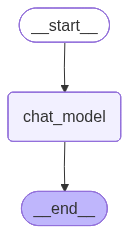

In [4]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Filter messages using RemoveMessage


In [5]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to explore:

1. **Dolphins**: These intelligent and social creatures are found all over the world. They are known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter, porpoises are also highly intelligent and social animals.

3. **Seals**: There are many species of seals, divided into two families: the earless or true seals and the eared seals, which include sea lions and fur seals.

4. **Sea Lions**: Known for their external ear flaps and barkin

## Test message filtering with RemoveMessage


**Reducer**
A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using RemoveMessage and the add_messages reducer.

## Filter messages by passing subset to LLM


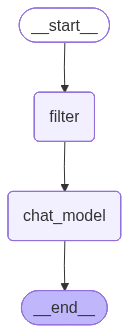

In [6]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Append new messages to conversation


In [7]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might be interested in learning about:

1. **Dolphins**: Closely related to whales, dolphins are highly intelligent and social animals known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and with different body shapes and behaviors. They are also part of the cetacean family.

3. **Seals**: These pinnipeds are known for their adaptability to marine life, with species like the harbor seal and leopard seal being quite well-known.

4. **Sea Lions**: Similar to seals 

## Display current messages


# **Filtering messages**
If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: llm.invoke(messages[-1:]) to the model.

## Invoke graph with filtered messages


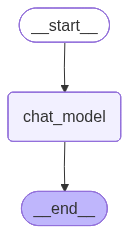

In [8]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Build graph with trim_messages


Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

## Add more messages for testing


In [ ]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

## Example: Trimming messages


In [17]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating types of ocean mammals you might want to explore. Here's a list to get you started:

1. **Dolphins** - These are highly intelligent and social creatures, with several species like the bottlenose dolphin and the orca, also known as killer whales, which are technically part of the dolphin family.

2. **Seals** - This group includes various species like the harbor seal and 

## Invoke graph with trimming


In [10]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might be interested in learning about:

1. **Dolphins**: Closely related to whales, dolphins are highly intelligent and social animals known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and with different body shapes and behaviors. They are also part of the cetacean famil

# **Trim messages**

Another approach is to trim messages, based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the trim_messages below.

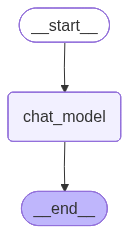

In [11]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

If we dont allow partial we get only the last message but if we allow it, then it will go back and include a total of 100 tokens.

In [17]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=True
        )

[AIMessage(content='\nUnderstanding these unique creatures is crucial, especially in the context of a rapidly changing Arctic environment, which poses challenges to their survival and the balance of their ecosystems.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 601, 'prompt_tokens': 17, 'total_tokens': 618, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-CmR19VCQr1eKcjuCSg1OalvMqkg9x', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b1983-f15c-7f03-9547-a7c045389b1f-0', usage_metadata={'input_tokens': 17, 'output_tokens': 601, 'total_tokens': 618, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'au

In [14]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})